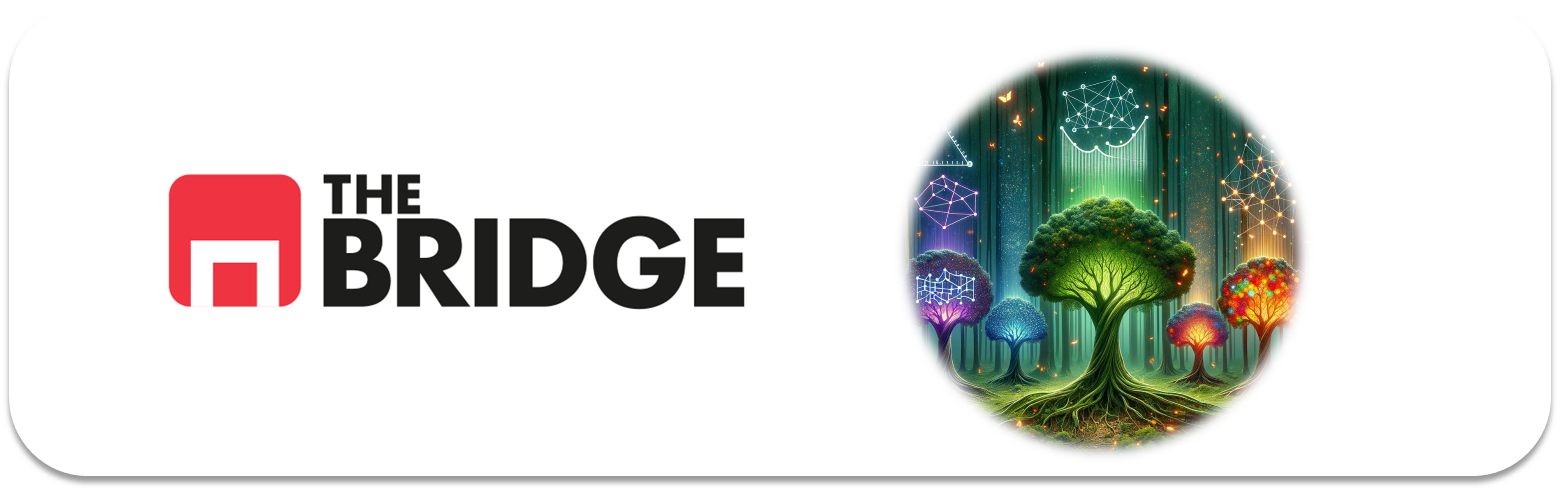

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [588]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bootcampviztools import plot_categorical_relationship_fin, plot_categorical_numerical_relationship, plot_grouped_histograms

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import chi2_contingency

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [589]:
df_marketing = pd.read_csv("./data/bank-full.csv", sep = ";")
df_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [590]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [591]:
for col in df_marketing:
    print(df_marketing[col].value_counts())

age
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
95       2
93       2
92       2
88       2
94       1
Name: count, Length: 77, dtype: int64
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
default
no     44396
yes      815
Name: count, dtype: int64
balance
0        3514
1         195
2         156
4         139
3         134
         ... 
14204       1
8205        1
9710        1
7038        1
4416        1
Name: count, Length: 7168, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64
loan
no     37967
yes

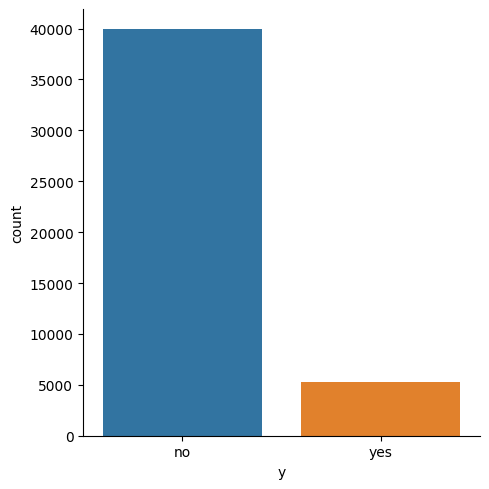

In [592]:
sns.catplot(data = df_marketing, x = "y", hue= "y", kind= "count")

*Está desbalanceado, probar class_weight*

#### *Transformación de binarias a números antes de hacer el split*

In [593]:
df_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [594]:
for col in df_marketing:
    if df_marketing[col].unique().tolist() == ["yes", "no"] or df_marketing[col].unique().tolist() == ["no", "yes"]:
        df_marketing.loc[df_marketing[col] == "yes", col] = 1
        df_marketing.loc[df_marketing[col] == "no", col] = 0
        df_marketing[col] = df_marketing[col].astype("int")

In [595]:
df_marketing.month.value_counts()

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

In [596]:
lista_meses = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
for no, mes in enumerate(lista_meses):
    df_marketing.loc[df_marketing.month == mes, "month"] = no + 1

df_marketing.month = df_marketing.month.astype("int")

df_marketing.month.value_counts()

month
5     13766
7      6895
8      6247
6      5341
11     3970
4      2932
2      2649
1      1403
10      738
9       579
3       477
12      214
Name: count, dtype: int64

#### *Train / Test split*

In [597]:
train, test = train_test_split(df_marketing, test_size= 0.2, stratify= df_marketing.y, random_state= 42)
print(train.y.value_counts(), test.y.value_counts())

y
0    31937
1     4231
Name: count, dtype: int64 y
0    7985
1    1058
Name: count, dtype: int64


In [598]:
df_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,-1,0,unknown,0


In [599]:
target = "y"
f_num = df_marketing.drop(columns= ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "y"]).columns.tolist()
f_cat = df_marketing.drop(columns= f_num + [target]).columns.tolist()
f_cat_bis = df_marketing.drop(columns= f_num + [target]).columns.tolist()

#### *Features numéricas*

In [600]:
f_num

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [601]:
np.abs(train[f_num + [target]].corr()[target]).sort_values(ascending = False)

y           1.000000
duration    0.396742
pdays       0.100703
previous    0.088847
campaign    0.071978
balance     0.055025
day         0.026595
age         0.024704
Name: y, dtype: float64

In [602]:
correlaciones = np.abs(train[f_num + [target]].corr()[target]).sort_values(ascending = False)
for col, corr in correlaciones.items():
    if corr < 0.07:
        f_num.remove(col)
f_num

['duration', 'campaign', 'pdays', 'previous']

In [603]:
f_num_bis = ['duration', 'campaign', 'pdays', 'previous']


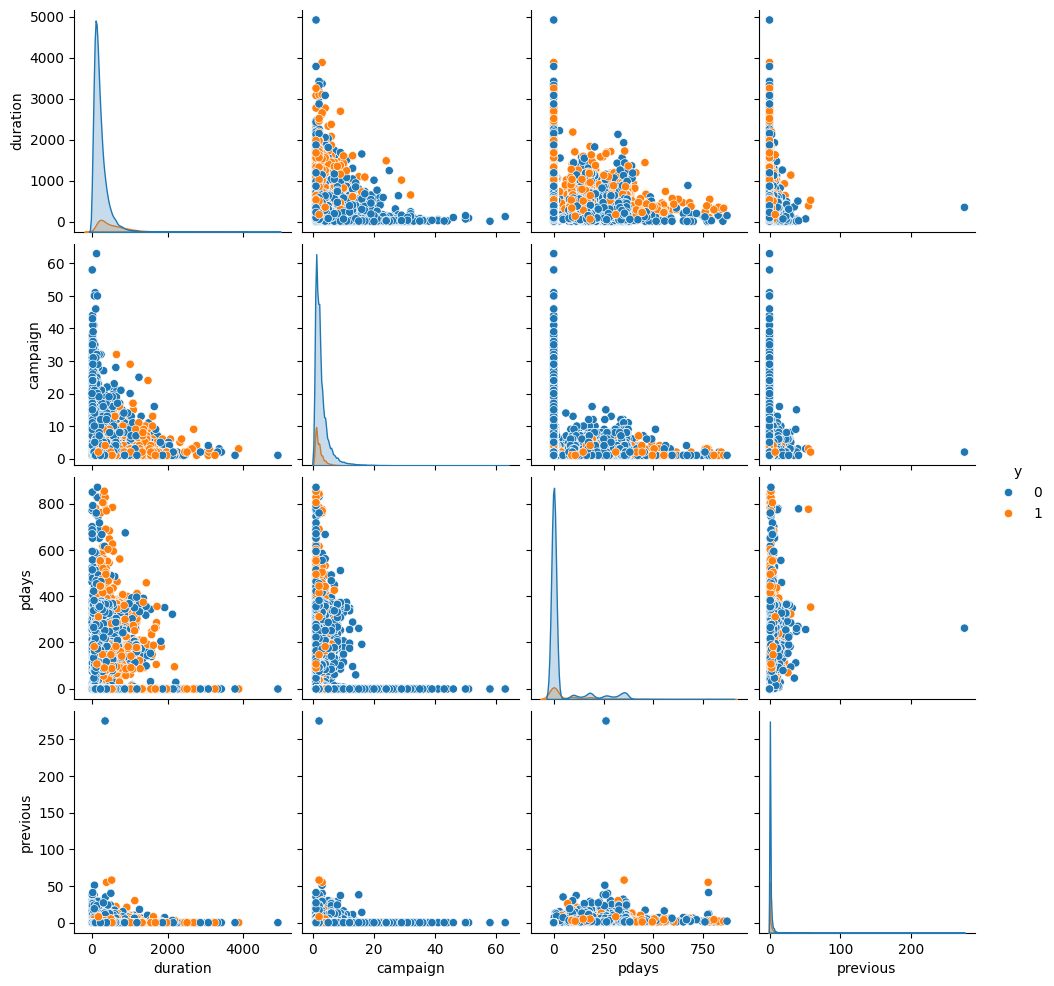

In [604]:
sns.pairplot(train[f_num + [target]], hue=target)

<Axes: >

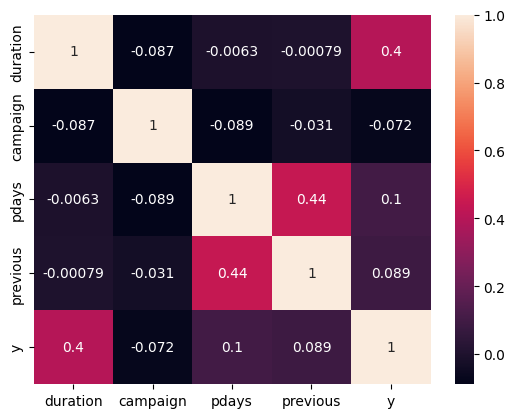

In [605]:
sns.heatmap(train[f_num + [target]].corr(), annot=True)

*Me quedo todas las que tienen una correlación mayor de 0.07, ya que entre ellas no tienen mucha correlación*

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

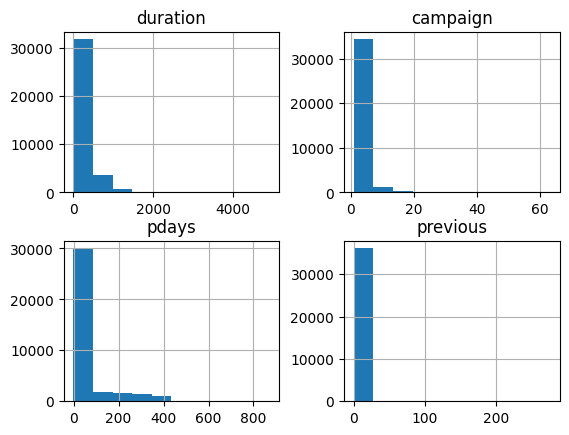

In [606]:
train[f_num].hist()

In [607]:

train["previous"].value_counts()

previous
0      29584
1       2232
2       1681
3        881
4        563
5        368
6        228
7        157
8        107
9         71
10        56
11        54
13        34
12        34
14        16
15        13
17        12
16        11
19         8
20         7
18         6
22         5
23         5
24         4
21         4
27         3
29         3
25         3
30         3
26         2
38         2
28         2
35         1
40         1
32         1
37         1
51         1
55         1
275        1
58         1
41         1
Name: count, dtype: int64

*Compruebo a ver si a previous y campaign les puede ir bien convertirla en categóricas, ya que parece que sus valores se agrupan muy muy al principio.*

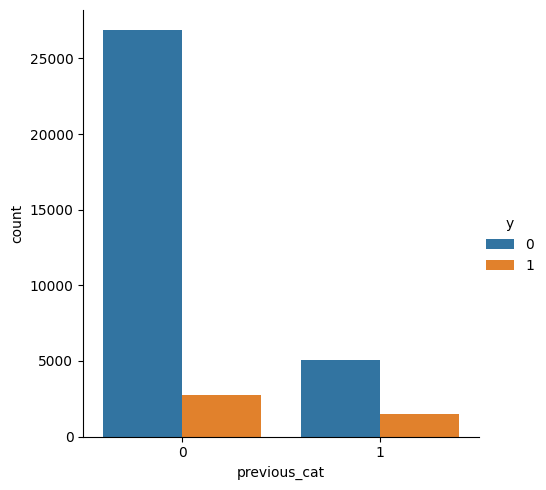

In [608]:
train["previous_cat"] = 0
train.loc[train.previous > 0, "previous_cat"] = 1
sns.catplot(data = train, x= "previous_cat", hue= target, kind="count")

In [609]:
train.groupby(target)["previous_cat"].value_counts(normalize = True)

y  previous_cat
0  0               0.840937
   1               0.159063
1  0               0.644528
   1               0.355472
Name: proportion, dtype: float64

In [610]:
test["previous_cat"] = 0
test.loc[test.previous > 0, "previous_cat"] = 1

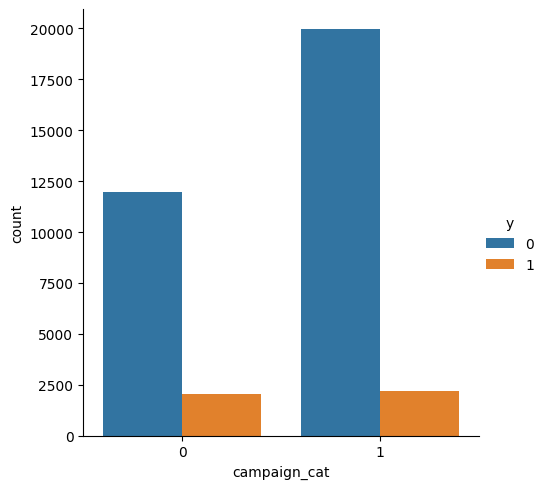

In [611]:
train["campaign_cat"] = 0
train.loc[train.campaign > 1, "campaign_cat"] = 1
sns.catplot(data = train, x= "campaign_cat", hue= target, kind="count")

In [612]:
train.groupby(target)["campaign_cat"].value_counts(normalize = True)

y  campaign_cat
0  1               0.624886
   0               0.375114
1  1               0.516426
   0               0.483574
Name: proportion, dtype: float64

In [613]:
test["campaign_cat"] = 0
test.loc[test.campaign > 1, "campaign_cat"] = 1

*Me quedo con las categóricas de las dos y las numéricas me las quedo en el bis para probarlas*

In [614]:
train_bis = train.copy().drop(columns = ["previous_cat", "campaign_cat"])
test_bis = test.copy().drop(columns = ["previous_cat", "campaign_cat"])

In [615]:
train.drop(columns = ["previous", "campaign"], inplace = True)
test.drop(columns = ["previous", "campaign"], inplace = True)

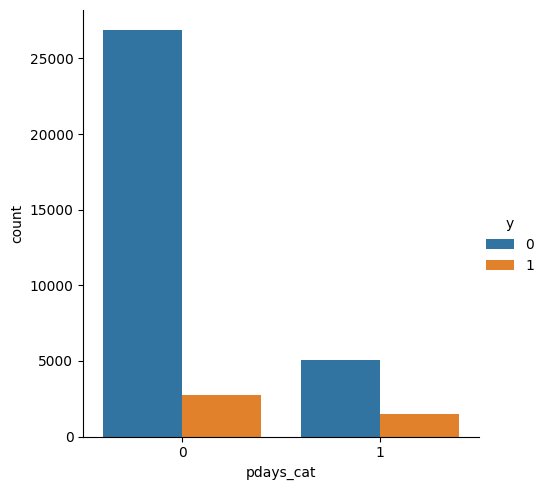

In [616]:
train["pdays_cat"] = 0
train.loc[train.pdays > 0, "pdays_cat"] = 1
sns.catplot(data = train, x= "pdays_cat", hue= target, kind="count")


In [617]:
train.groupby(target)["pdays_cat"].value_counts(normalize = True)

y  pdays_cat
0  0            0.840937
   1            0.159063
1  0            0.644528
   1            0.355472
Name: proportion, dtype: float64

In [618]:
train.pdays_cat == train.previous_cat

24001    True
43409    True
20669    True
18810    True
23130    True
         ... 
17958    True
15941    True
16952    True
34781    True
44229    True
Length: 36168, dtype: bool

In [619]:
f_num = ["duration", "pdays"]

In [620]:
for col in f_num:
    train[col] = (train[col] + 2).apply(np.log)
    test[col] = (test[col] + 2).apply(np.log)

In [621]:
train[f_num].describe()

,duration,pdays
count,36168.000000,36168.000000
mean,5.181206,0.956085
std,0.911706,2.048287
min,0.693147,0.000000
25%,4.653960,0.000000
50%,5.204007,0.000000
75%,5.768321,0.000000
max,8.501064,6.771936


In [622]:
scaler = StandardScaler()

train[f_num] = scaler.fit_transform(train[f_num])
test[f_num] = scaler.transform(test[f_num])

*Ya he tratado las numéricas, ahora voy a las categóricas*

In [623]:
test.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'pdays', 'poutcome', 'y',
       'previous_cat', 'campaign_cat'],
      dtype='object')

In [624]:
f_cat += ['previous_cat', 'campaign_cat']

*Primero añado las nuevas que ya sé que me voy a quedar*

In [625]:
f_cat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'previous_cat',
 'campaign_cat']

In [626]:
train = train.copy()[f_cat + f_num + [target]]
test = test.copy()[f_cat + f_num + [target]]
train_bis = train_bis.copy()[f_cat_bis + f_num_bis + [target]]
test_bis = test_bis.copy()[f_cat_bis + f_num_bis + [target]]

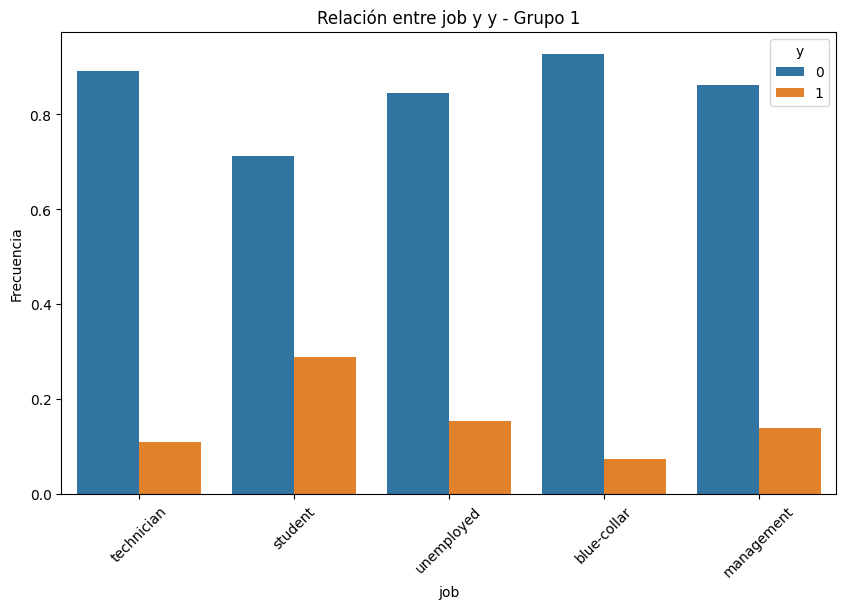

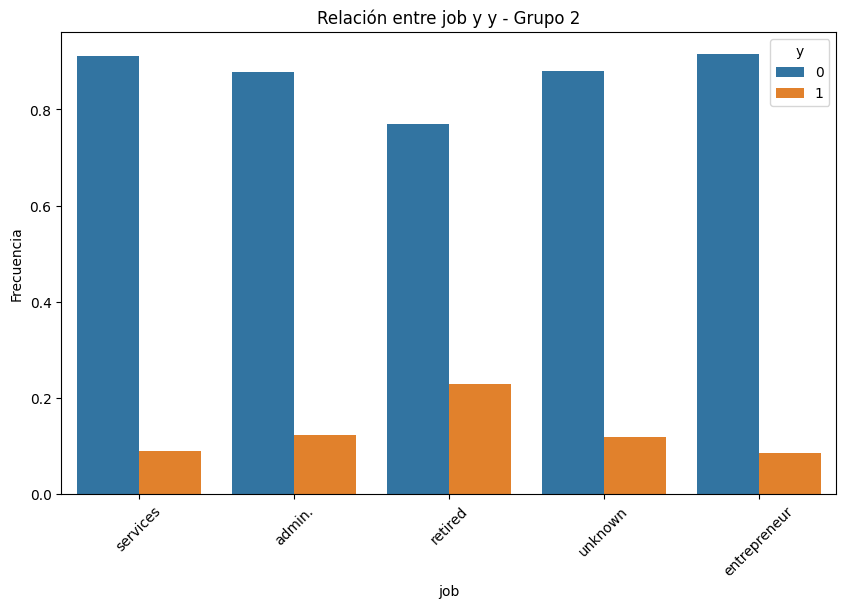

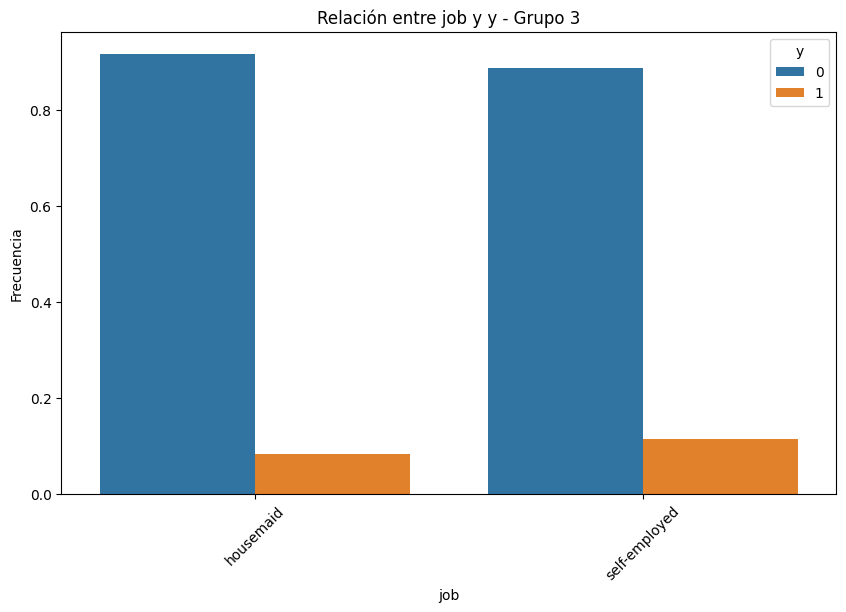

In [627]:
plot_categorical_relationship_fin(train, "job", "y", relative_freq=True)

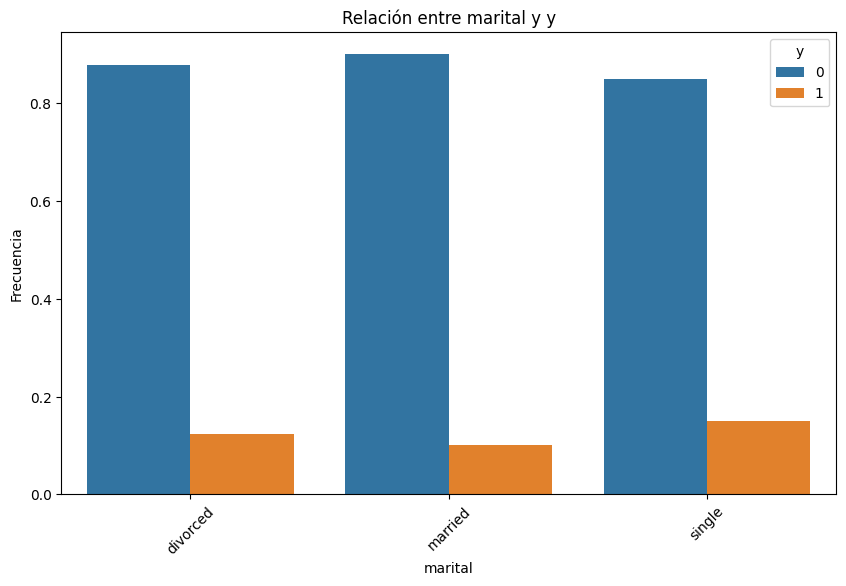

In [628]:
plot_categorical_relationship_fin(train, "marital", "y", relative_freq=True)

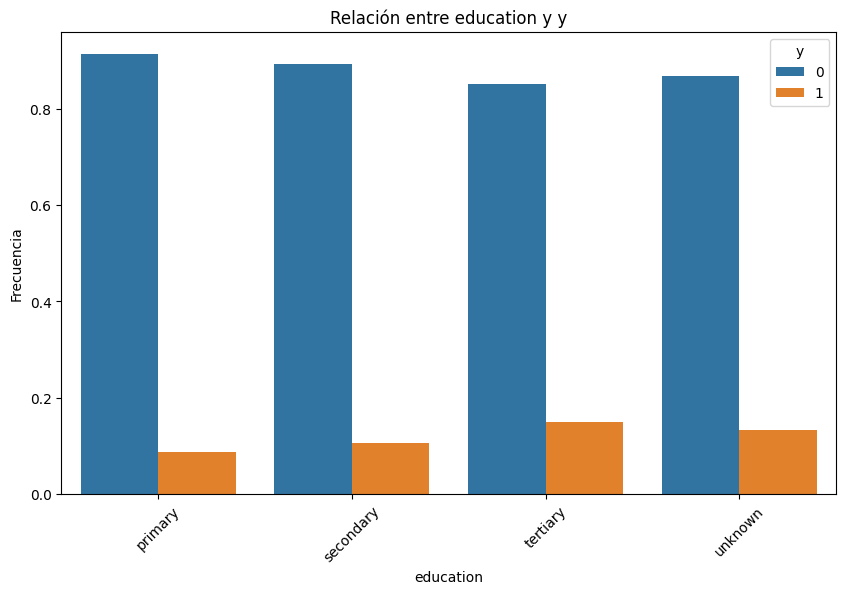

In [629]:
plot_categorical_relationship_fin(train, "education", "y", relative_freq=True)

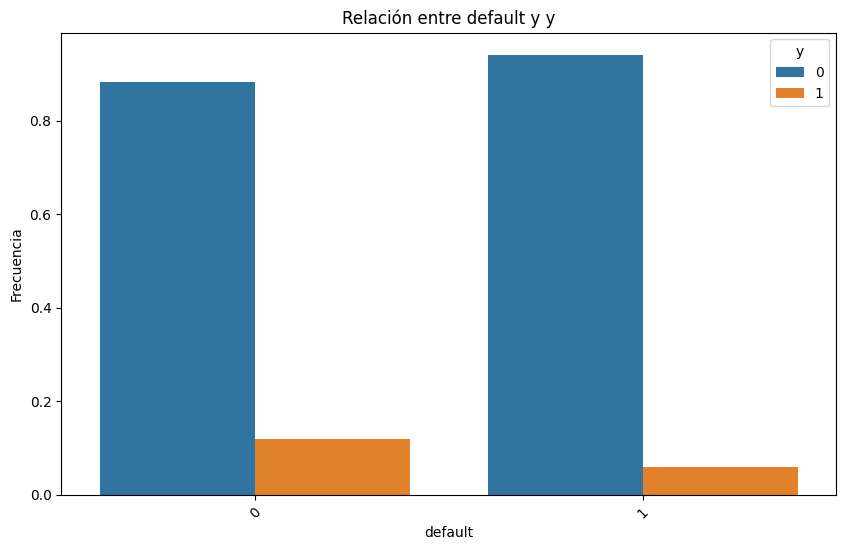

In [630]:
plot_categorical_relationship_fin(train, "default", "y", relative_freq=True)

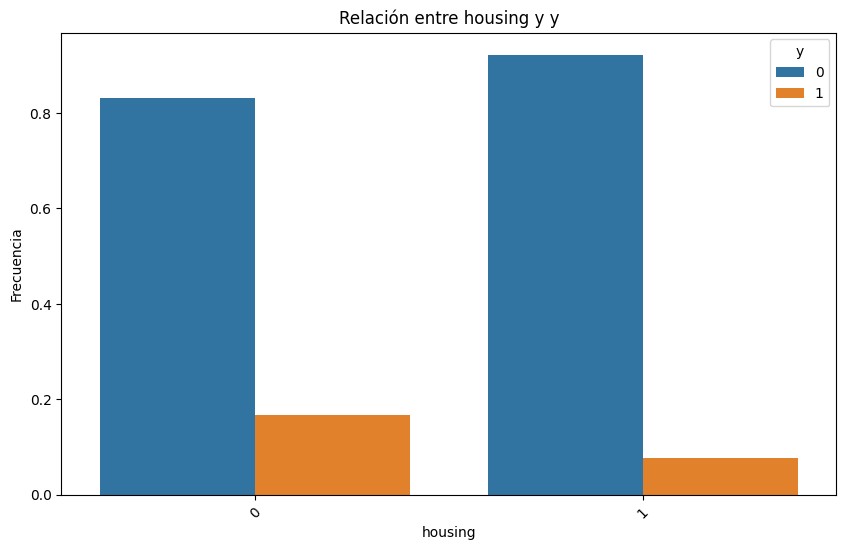

In [631]:
plot_categorical_relationship_fin(train, "housing", "y", relative_freq=True)

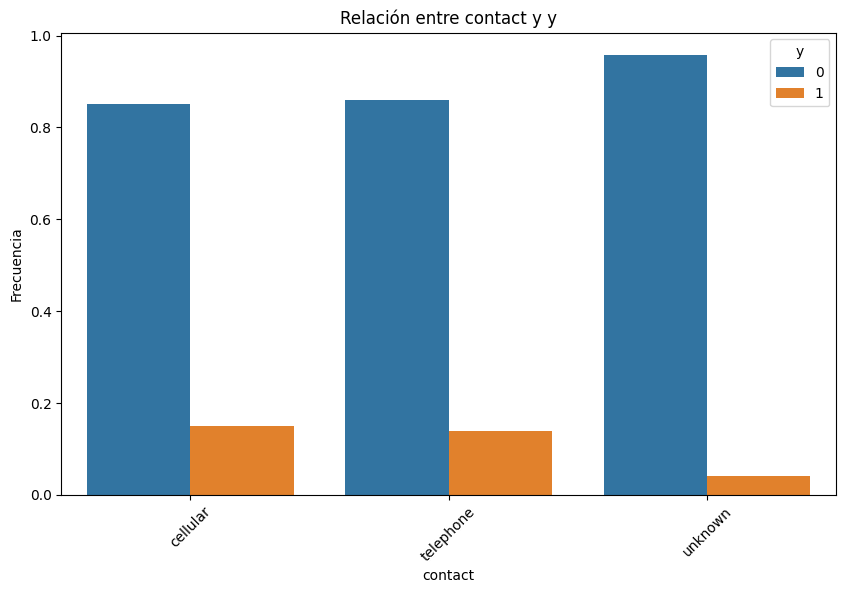

In [632]:
plot_categorical_relationship_fin(train, "contact", "y", relative_freq=True)

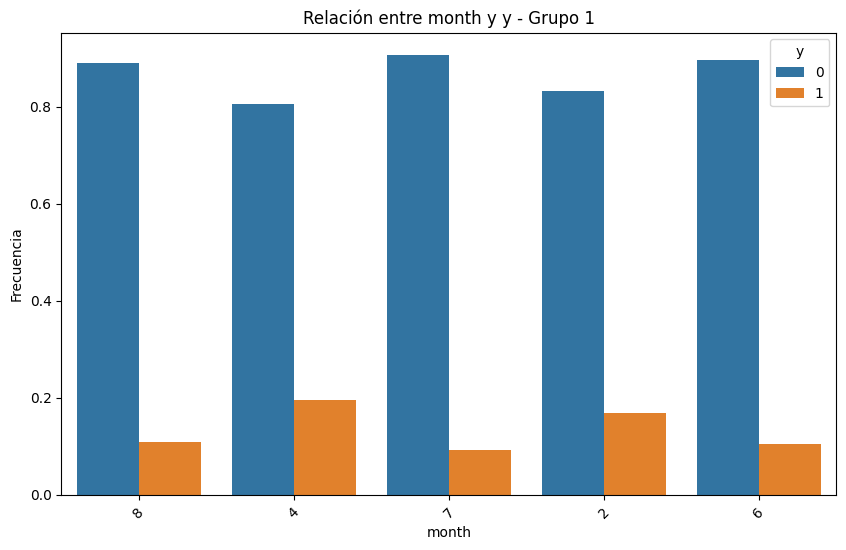

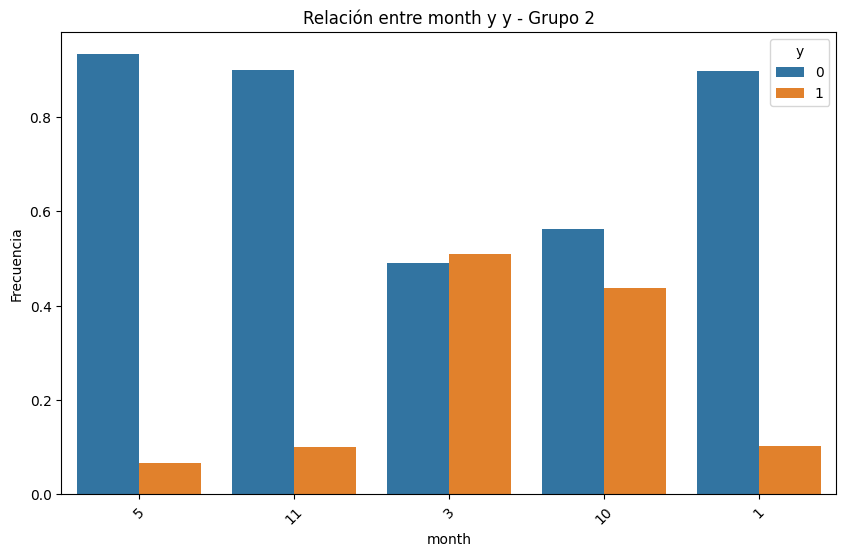

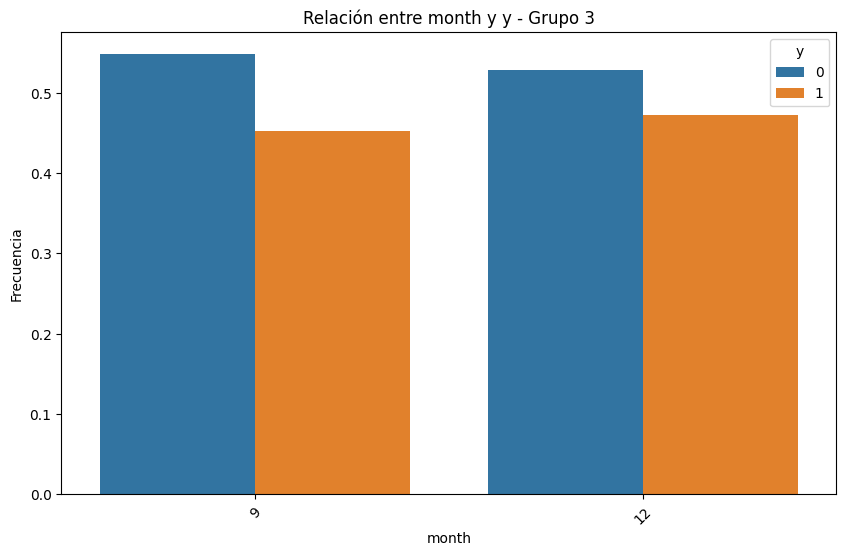

In [633]:
plot_categorical_relationship_fin(train, "month", "y", relative_freq=True)

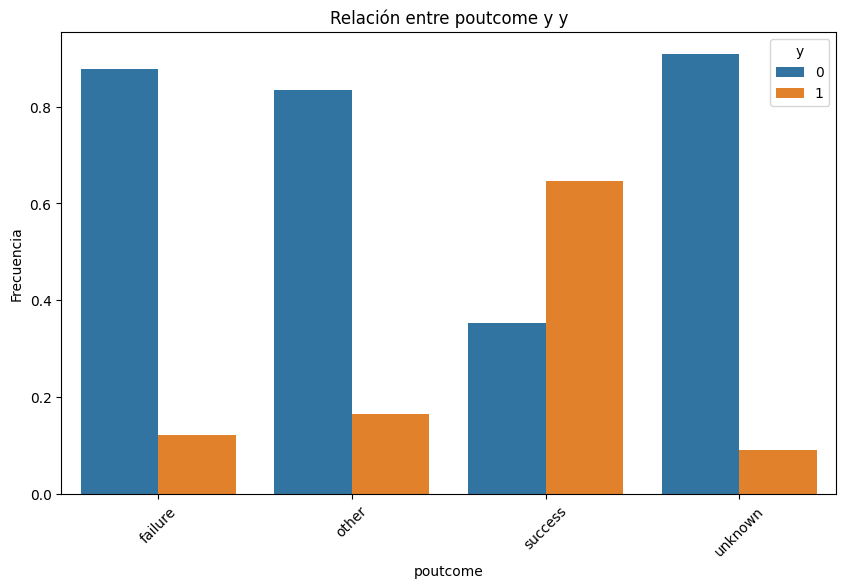

In [634]:
plot_categorical_relationship_fin(train, "poutcome", "y", relative_freq=True)

In [635]:
for col in train[f_cat]:
    tabla_contingecia = pd.crosstab(train[target], train[col])
    chi2, p_value, dof, expected = chi2_contingency(tabla_contingecia)
    print(f"P-Value para descartar que '{col}' y target no están relacionadas: {p_value}")

P-Value para descartar que 'job' y target no están relacionadas: 3.3453047561653717e-140
P-Value para descartar que 'marital' y target no están relacionadas: 3.30208648314554e-37
P-Value para descartar que 'education' y target no están relacionadas: 3.841322927500508e-38
P-Value para descartar que 'default' y target no están relacionadas: 4.43134030981534e-06
P-Value para descartar que 'housing' y target no están relacionadas: 9.576248624376933e-155
P-Value para descartar que 'loan' y target no están relacionadas: 1.4553953289289069e-36
P-Value para descartar que 'contact' y target no están relacionadas: 2.2216425534984923e-177
P-Value para descartar que 'month' y target no están relacionadas: 0.0
P-Value para descartar que 'poutcome' y target no están relacionadas: 0.0
P-Value para descartar que 'previous_cat' y target no están relacionadas: 3.2829416966473185e-212
P-Value para descartar que 'campaign_cat' y target no están relacionadas: 4.6502991737683377e-42


*Haciendo el test chi cuadrado no podemos descartar que exista relación con ninguna de las categóricas, por lo que me las quedo todas, voy a tratarlas*

In [636]:
train["marital"]

24001    divorced
43409      single
20669      single
18810     married
23130     married
           ...   
17958     married
15941      single
16952     married
34781      single
44229     married
Name: marital, Length: 36168, dtype: object

*Marital sí que puede tener un cierto orden, por lo que le voy a aplicar un ordinal encoding, a education también, los unknown me descuadran un poco pero al ser pocos les voy a poner 0, a las demás one-hot encoding. Voy a hacer un bis con solo one-hot encoding.*

In [637]:
train_bck = train.copy()
test_bck = test.copy()

In [638]:
categories = [["single", "married", "divorced"]]
ordinal_encoder = OrdinalEncoder(categories=categories)
train["marital"] = ordinal_encoder.fit_transform(train[["marital"]])
train.marital = train.marital.astype("int")

In [639]:
test.marital = ordinal_encoder.fit_transform(test[["marital"]])
test.marital = test.marital.astype("int")
test

,job,marital,education,default,housing,loan,contact,month,poutcome,previous_cat,campaign_cat,duration,pdays,y
1392,blue-collar,1,primary,0,1,1,unknown,5,unknown,0,1,0.739137,-0.466780,0
7518,technician,1,secondary,0,1,0,unknown,5,unknown,0,1,0.155540,-0.466780,0
12007,services,1,secondary,0,1,0,unknown,6,unknown,0,1,0.281755,-0.466780,0
5536,blue-collar,1,primary,0,1,0,unknown,5,unknown,0,1,-0.151126,-0.466780,0
29816,services,0,secondary,0,1,0,cellular,2,unknown,0,0,-1.138619,-0.466780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,blue-collar,0,secondary,0,0,1,unknown,7,unknown,0,0,1.493119,-0.466780,0
13364,services,1,secondary,0,1,0,telephone,7,unknown,0,1,0.144786,-0.466780,0
16102,entrepreneur,1,tertiary,0,1,0,cellular,7,unknown,0,1,0.809141,-0.466780,0
42097,student,0,primary,0,0,0,cellular,11,failure,1,1,-1.007494,2.079254,0


In [640]:
categories = [["unknown", "primary", "secondary", "tertiary"]]
ordinal_encoder = OrdinalEncoder(categories=categories)
train["education"] = ordinal_encoder.fit_transform(train[["education"]])
train.education = train.education.astype("int")
test.education = ordinal_encoder.fit_transform(test[["education"]])
test.education = test.education.astype("int")
test

,job,marital,education,default,housing,loan,contact,month,poutcome,previous_cat,campaign_cat,duration,pdays,y
1392,blue-collar,1,1,0,1,1,unknown,5,unknown,0,1,0.739137,-0.466780,0
7518,technician,1,2,0,1,0,unknown,5,unknown,0,1,0.155540,-0.466780,0
12007,services,1,2,0,1,0,unknown,6,unknown,0,1,0.281755,-0.466780,0
5536,blue-collar,1,1,0,1,0,unknown,5,unknown,0,1,-0.151126,-0.466780,0
29816,services,0,2,0,1,0,cellular,2,unknown,0,0,-1.138619,-0.466780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,blue-collar,0,2,0,0,1,unknown,7,unknown,0,0,1.493119,-0.466780,0
13364,services,1,2,0,1,0,telephone,7,unknown,0,1,0.144786,-0.466780,0
16102,entrepreneur,1,3,0,1,0,cellular,7,unknown,0,1,0.809141,-0.466780,0
42097,student,0,1,0,0,0,cellular,11,failure,1,1,-1.007494,2.079254,0


In [641]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 24001 to 44229
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job           36168 non-null  object 
 1   marital       36168 non-null  int64  
 2   education     36168 non-null  int64  
 3   default       36168 non-null  int64  
 4   housing       36168 non-null  int64  
 5   loan          36168 non-null  int64  
 6   contact       36168 non-null  object 
 7   month         36168 non-null  int64  
 8   poutcome      36168 non-null  object 
 9   previous_cat  36168 non-null  int64  
 10  campaign_cat  36168 non-null  int64  
 11  duration      36168 non-null  float64
 12  pdays         36168 non-null  float64
 13  y             36168 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 4.1+ MB


In [642]:
col_dummies = []
for col in f_cat:
    if train[col].dtype == "object":
        col_dummies.append(col)

train = pd.get_dummies(train, columns = col_dummies, dtype="int")
test = pd.get_dummies(test, columns = col_dummies, dtype="int")

In [643]:
col_dummies = []
for col in f_cat_bis:
    if train_bis[col].dtype == "object":
        col_dummies.append(col)

train_bis = pd.get_dummies(train_bis, columns = col_dummies, dtype="int")
test_bis = pd.get_dummies(test_bis, columns = col_dummies, dtype="int")

In [644]:
train

,marital,education,default,housing,loan,month,previous_cat,campaign_cat,duration,pdays,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
24001,2,2,0,0,0,8,0,1,-0.247209,-0.46678,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
43409,0,2,0,0,0,4,1,1,1.789132,2.08715,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
20669,0,2,0,1,0,8,0,1,2.499426,-0.46678,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
18810,1,2,0,0,0,7,0,1,-1.722386,-0.46678,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
23130,1,2,0,0,0,8,0,1,-1.210570,-0.46678,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,1,2,0,1,0,7,0,1,-1.192135,-0.46678,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
15941,0,2,0,1,0,7,0,1,-0.890385,-0.46678,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
16952,1,2,0,1,0,7,0,0,-0.631830,-0.46678,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
34781,0,3,0,1,0,5,0,0,0.276975,-0.46678,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [645]:
features = train.drop(columns= target).columns.to_list()
len(features)

29

In [646]:
X_train = train[features].copy()
y_train = train[target].copy()
X_test = test[features].copy()
y_test = test[target].copy()

## *Baseline*
DecisionTree solo con parámetro max_depth = 4   
LogisticRegression sin hiperparámetros

In [652]:
reg_tree = DecisionTreeClassifier(random_state=42)
reg_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

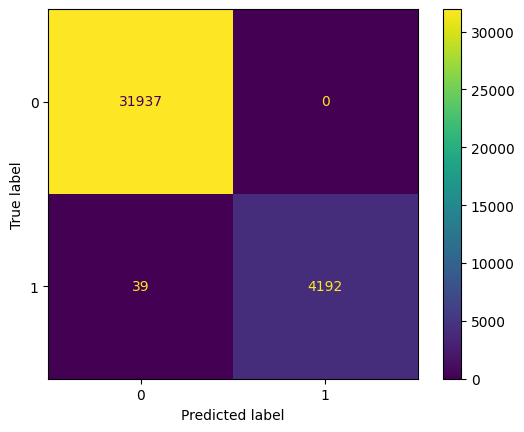

In [653]:
pred_train = reg_tree.predict(X_train)
c_matrix = ConfusionMatrixDisplay(confusion_matrix="cm")
c_matrix.from_predictions(y_train, pred_train)

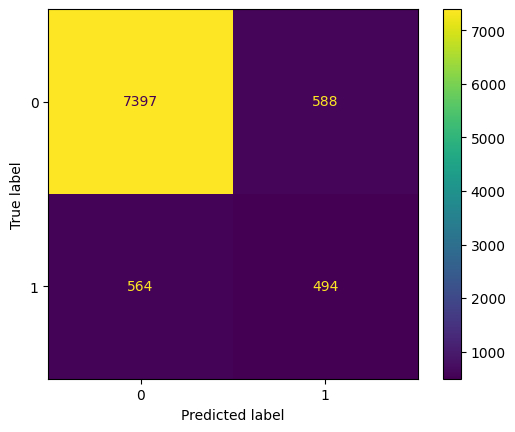

In [654]:
pred_test = reg_tree.predict(X_test)
c_matrix = ConfusionMatrixDisplay(confusion_matrix="cm")
c_matrix.from_predictions(y_test, pred_test)

In [655]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.47      0.46      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.70      0.69      9043
weighted avg       0.87      0.87      0.87      9043



In [651]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
pred_test = log_reg.predict(X_test)

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.33      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



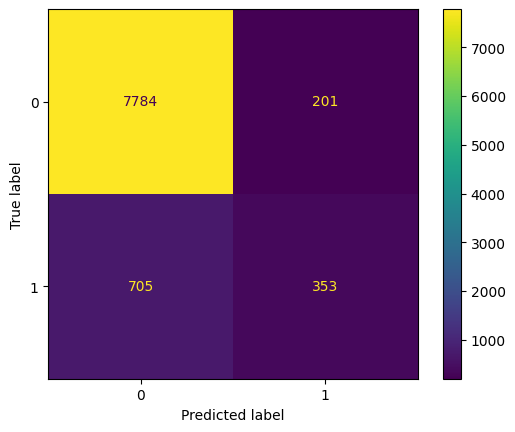

In [587]:
c_matrix.from_predictions(y_test, pred_test)

## *Optimizados*
1. Con RandomSearch
2. Con GridSearch y "balanceado"

In [531]:
param_grid = {
    "max_depth" : np.arange(3, 10, 1),
    "max_leaf_nodes" : np.arange(20, 50, 1)
}

reg_tree = DecisionTreeClassifier()
random_search = RandomizedSearchCV(reg_tree,
                                   param_grid,
                                   random_state=42,
                                   n_iter = 100,
                                   cv = 5,
                                   scoring= "recall",
                                   n_jobs = -1)

In [532]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_leaf_nodes': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=42, scoring='recall')

In [533]:
random_search.best_params_

{'max_leaf_nodes': np.int64(48), 'max_depth': np.int64(8)}

In [534]:
random_search.best_score_

np.float64(0.4311093806258216)

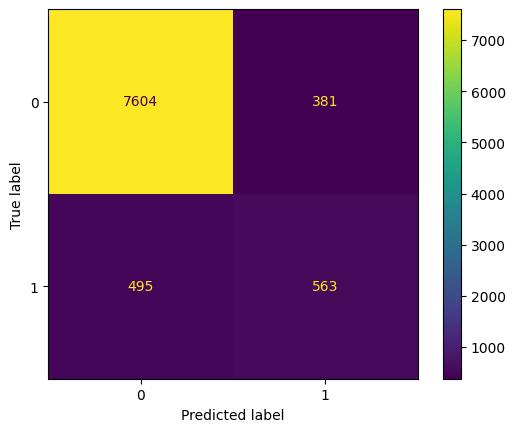

In [535]:
pred_test = random_search.best_estimator_.predict(X_test)
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test, pred_test)

In [536]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.60      0.53      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.74      0.75      9043
weighted avg       0.90      0.90      0.90      9043



In [689]:
param_grid = {
    "max_depth" : np.arange(3, 10, 1),
    "max_leaf_nodes" : np.arange(20, 50, 1),
    "class_weight": ["balanced"],
    "min_samples_leaf": [1,10,20,100],
    "max_features": ['sqrt', 'log2', None]
}

reg_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(reg_tree,
                            param_grid,
                            cv = 5,
                            scoring= "balanced_accuracy",
                            n_jobs = -1)

In [690]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'min_samples_leaf': [1, 10, 20, 100]},
             scoring='balanced_accuracy')

In [691]:
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': np.int64(9),
 'max_features': None,
 'max_leaf_nodes': np.int64(47),
 'min_samples_leaf': 1}

In [692]:
grid_search.best_score_

np.float64(0.8381254567894636)

In [687]:
pred_test = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7985
           1       0.35      0.88      0.50      1058

    accuracy                           0.79      9043
   macro avg       0.66      0.83      0.69      9043
weighted avg       0.91      0.79      0.83      9043



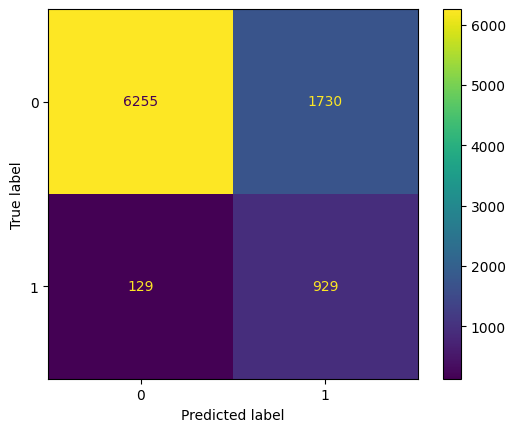

In [688]:
c_matrix.from_predictions(y_test, pred_test)

In [565]:
reg_tree = DecisionTreeClassifier(max_depth= 8, max_leaf_nodes= 48, class_weight= "balanced")
reg_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_leaf_nodes=48)

In [566]:
pred_test = reg_tree.predict(X_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7985
           1       0.36      0.86      0.50      1058

    accuracy                           0.80      9043
   macro avg       0.67      0.83      0.69      9043
weighted avg       0.90      0.80      0.83      9043



*El modelo generaliza bien, he buscado maximizar el recall de 1, buscando encontrar al máximo número de clientes que vayan a responder positivamente a una campaña de marketing, si hay personas que predecimos que sí responderán y luego no responden positivamente es menos importante.*